# 1. IMPORTS 

In [542]:
import pandas as pd
from inflection import underscore
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder

## 1. 1 HELPER FUNCTIONS

In [543]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')
sns.set_style('whitegrid', {'grid.color': '.7'})
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.rcParams["figure.figsize"] = (30, 10)

## 1.2 LOADING DATA

In [544]:
df_store = pd.read_csv('./datasets/store.csv', low_memory = False)
df_train = pd.read_csv('./datasets/train.csv', low_memory = False)
df_raw = df_store.merge(df_train, how='left', on='Store')

# 2. DATA DESCRIPTION 

## 2.1 RENAME COLUMNS

In [545]:
# Trasorming columns names into snake_case
old_cols = df_raw.columns.to_list()
new_cols = [underscore(w) for w in old_cols]
df_raw.columns = new_cols

## 2.2 DATA DIMENSIONS

In [546]:
print(f'Dataset has {df_raw.shape[0]} lines and {df_raw.shape[1]} columns')

Dataset has 1017209 lines and 18 columns


## 2.3 CHECK DTYPES

In [547]:
df_raw.dtypes

store                             int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
dtype: object

## 2.4 CHECK NA

In [2]:
df_raw.isna().sum()

NameError: name 'df_raw' is not defined

## 2.5 FILL NA VALUES

In [549]:
#Para não dar erro é preciso converter a coluna 'date' para datetime antes de preencher os valores NA.
df_raw['date'] = pd.to_datetime( df_raw['date'] ) 

In [550]:
# competition_distance ( vamos trocar os NA's por uma distnacia muito grande, presumindo que não exista competição próxima)
df_raw['competition_distance'] = df_raw['competition_distance'].apply(lambda x: 20000 if pd.isna( x ) else x).astype('int64')

# competition_open_since_month ( qunando for NA vamos substituir pelo mês da data atual)
df_raw['competition_open_since_month']  = df_raw.apply(lambda x: x['date'].month if pd.isna( x['competition_open_since_month'] )  else x['competition_open_since_month'], axis = 1)

# competition_open_since_year
df_raw['competition_open_since_year']  = df_raw.apply(lambda x: x['date'].year if pd.isna( x['competition_open_since_year'] )  else x['competition_open_since_year'], axis = 1)

# promo2_since_week
df_raw['promo2_since_week'] = df_raw.apply(lambda x: x['date'].week if pd.isna( x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year
df_raw['promo2_since_year'] = df_raw.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year']) else x['promo2_since_year' ], axis = 1) 

# promo_interval

df_raw['promo_interval'].fillna(0, inplace=True)

#Fazer isso no feature engineering ? 
month_map = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df_raw['month_map'] = df_raw['date'].dt.month.map( month_map )
df_raw['is_promo'] = df_raw.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if str( x['month_map'] ) in str( x['promo_interval']) else 0, axis=1)

## 2.6 CHANGE DTYPES

In [551]:
# Transforming 'date' columns into datetime
df_raw['date'] = pd.to_datetime( df_raw['date'] )

# competition_open_since_month into int
df_raw['competition_open_since_month'] = df_raw['competition_open_since_month'].astype( 'int64' )

# competition_open_since_year into int
df_raw['competition_open_since_year']  = df_raw['competition_open_since_year'].astype( 'int64' )

# promo2_since_week into int
df_raw['promo2_since_week'] = df_raw['promo2_since_week'].astype( 'int64' )

# promo2_since_year into int
df_raw['promo2_since_year'] = df_raw['promo2_since_year'].astype( 'int64' )

## 2.7 DESCRIPTIVE STATISTICS

In [552]:
num_attributes = df_raw.select_dtypes( include = ['int64', 'float64'])
cat_attributes = df_raw.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

In [553]:
num_attributes.describe()

,store,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,day_of_week,sales,customers,open,promo,school_holiday,is_promo
count,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00
mean,558.43,5467.93,6.79,2010.32,0.50,23.62,2012.79,4.00,5773.82,633.15,0.83,0.38,0.18,0.17
std,321.91,7740.90,3.31,5.52,0.50,14.31,1.66,2.00,3849.93,464.41,0.38,0.49,0.38,0.38
min,1.00,20.00,1.00,1900.00,0.00,1.00,2009.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,280.00,710.00,4.00,2008.00,0.00,12.00,2012.00,2.00,3727.00,405.00,1.00,0.00,0.00,0.00
50%,558.00,2330.00,7.00,2012.00,1.00,22.00,2013.00,4.00,5744.00,609.00,1.00,0.00,0.00,0.00
75%,838.00,6910.00,10.00,2014.00,1.00,37.00,2014.00,6.00,7856.00,837.00,1.00,1.00,0.00,0.00
max,1115.00,75860.00,12.00,2015.00,1.00,52.00,2015.00,7.00,41551.00,7388.00,1.00,1.00,1.00,1.00


In [554]:
# Central Tendency
mean   = pd.DataFrame( num_attributes.apply( np.mean ) ).T
median = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis,
std      = pd.DataFrame( num_attributes.apply( np.std ) ).T
minimum  = pd.DataFrame( num_attributes.apply( min ) ).T
maximum  = pd.DataFrame( num_attributes.apply( max ) ).T
range_   = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
skew     = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
kurtosis = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

metrics = pd.concat( [mean, median, std, minimum, maximum, range_, skew, kurtosis] ).T.reset_index()

In [555]:
metrics

,index,0,0,0,0,0,0,0,0
0,store,558.43,558.00,321.91,1.00,1115.00,1114.00,-0.00,-1.20
1,competition_distance,5467.93,2330.00,7740.90,20.00,75860.00,75840.00,2.89,12.72
2,competition_open_since_month,6.79,7.00,3.31,1.00,12.00,11.00,-0.04,-1.23
3,competition_open_since_year,2010.32,2012.00,5.52,1900.00,2015.00,115.00,-7.24,124.07
4,promo2,0.50,1.00,0.50,0.00,1.00,1.00,-0.00,-2.00
5,promo2_since_week,23.62,22.00,14.31,1.00,52.00,51.00,0.18,-1.18
6,promo2_since_year,2012.79,2013.00,1.66,2009.00,2015.00,6.00,-0.78,-0.21
7,day_of_week,4.00,4.00,2.00,1.00,7.00,6.00,0.00,-1.25
8,sales,5773.82,5744.00,3849.92,0.00,41551.00,41551.00,0.64,1.78
9,customers,633.15,609.00,464.41,0.00,7388.00,7388.00,1.60,7.09


In [556]:
metrics.columns = ['column', 'mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']

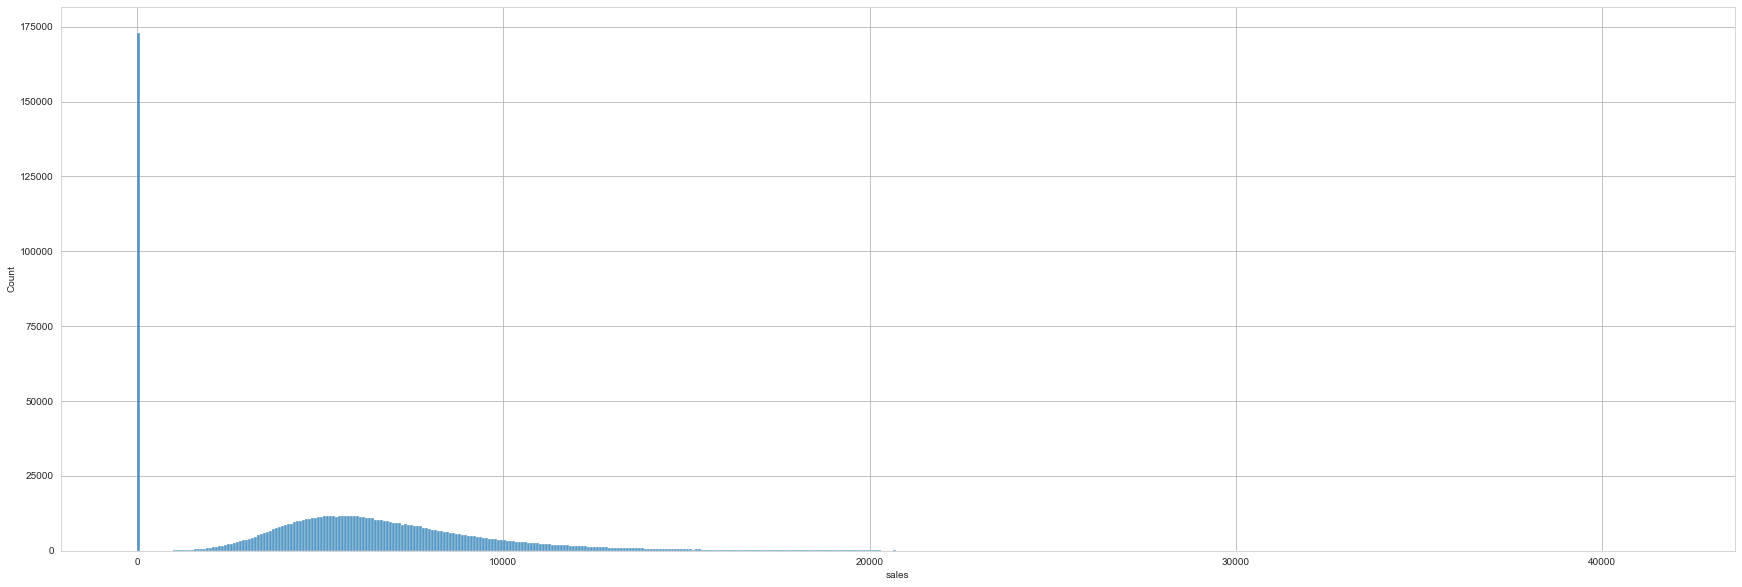

In [557]:
sns.histplot( data=df_raw['sales'] );

In [558]:
cat_attributes.head()

,store_type,assortment,promo_interval,state_holiday,month_map
0,c,a,0,0,Jul
1,c,a,0,0,Jul
2,c,a,0,0,Jul
3,c,a,0,0,Jul
4,c,a,0,0,Jul


''

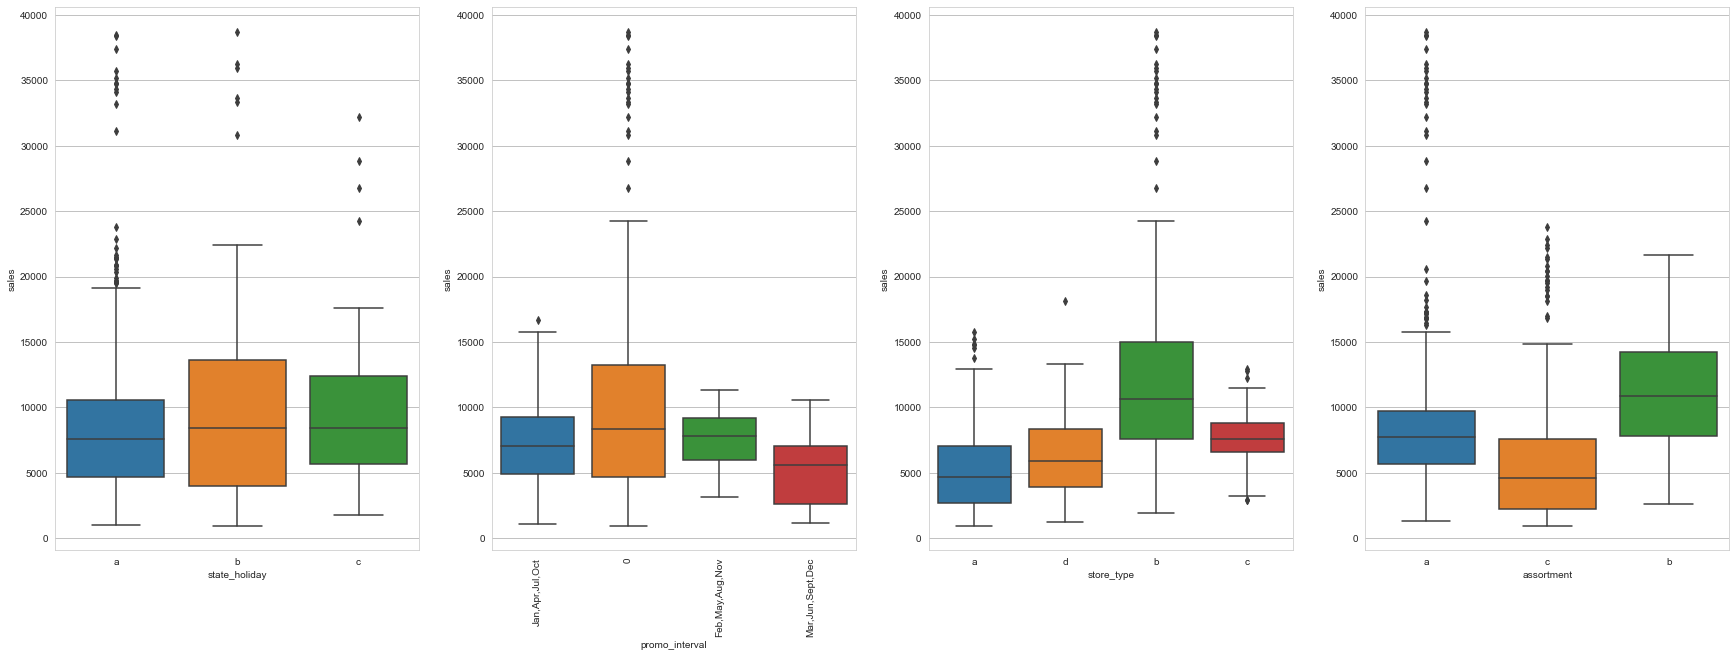

In [559]:
plt.GridSpec(1, 2)

plt.subplot(1, 4, 1)
aux1 = df_raw[(df_raw['sales'] > 0) & (df_raw['state_holiday'] != '0')]
sns.boxplot (data=aux1, x='state_holiday', y='sales' )

plt.subplot(1, 4, 2)
aux2 = df_raw[(df_raw['sales'] > 0) & (df_raw['promo_interval'] != 0)]
sns.boxplot(data=aux1, x='promo_interval', y='sales')
plt.xticks(rotation=90)

plt.subplot(1, 4, 3)
aux3 = df_raw[(df_raw['sales'] > 0) & (df_raw['store_type'] != '0')]
sns.boxplot(data=aux1, x='store_type', y='sales')

plt.subplot(1, 4, 4)
aux4 = df_raw[(df_raw['sales'] > 0) & (df_raw['assortment'] != '0')]
sns.boxplot(data=aux1, x='assortment', y='sales')


;

# 3. FEATURE ENGINEERING 

## 3.1 HIPÓTESES A SEREM TESTADAS

1. Lojas com maior sortimento deveriam vender mais
2. Lojas com competidores mais próximos deveriam vender menos
3. Lojas com competidores à mais tempo vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas durante o feriado de Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana
12. Lojas deveriam vender menos durante os feriados escolares.

In [560]:
df1 = df_raw.copy()

## 3.2 FEATURE ENGINEERING

In [561]:
df1['date'].head()

0   2015-07-31
1   2015-07-30
2   2015-07-29
3   2015-07-28
4   2015-07-27
Name: date, dtype: datetime64[ns]

In [562]:
df1.dtypes

store                                    int64
store_type                              object
assortment                              object
competition_distance                     int64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
month_map                               object
is_promo                                 int64
dtype: object

In [589]:
#year
df1['year'] = df1['date'].dt.year

# month
df1['month'] = df1['date'].dt.month

#day
df1['day'] = df1['date'].dt.day

# week of year
df1['week_of_year'] = df1['date'].dt.isocalendar().week

#year week
df1['year_week'] = df1['date'].dt.strftime( '%Y-%W')

# competition_since
df1['competition_since'] = df1.apply(lambda x: datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day=1), axis = 1)
df1['competition_time_month'] =  ((df1['date'] - df1['competition_since'] ) / 30 ).apply(lambda x: x.days).astype( int )

#---------------------------------------------------------------------------------------------
# promo since
df1['promo_since'] = df1['promo2_since_year'].astype( str ) + '-' + df1['promo2_since_week'].astype( str )
df1['promo_since'] = df1['promo_since'].apply( lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7)) # descobrir por que subtraiu 7 dias e o strptime
df1['promo_time_week'] = ( ( df1['date'] - df1['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

# assortment describes an assortment level: a = basic, b = extra, c = extended
df1['assortment'] = df1['assortment'].apply (lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df1['state_holiday'] = df1['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 4. FILTRAGEM DAS VARIÁVEIS

In [591]:
df2 = df1.copy()

## 4.1 FILTRAGEM DAS LINHAS

In [565]:
df2 = df2[( df2['open'] != 0) & (df2['sales'] > 0) ]

## 4.2 SELEÇÃO DAS COLUNAS

In [566]:
df2.drop(columns=['customers','open', 'month_map', 'promo_interval'], inplace=True)

#  5. ANÁLISE EXPLORATÓRIA DE DADOS

In [592]:
df3 = df2.copy()

## 5.1 ANÁLISE UNIVARIADA

### 5.1.1 RESPONSE VARIABLE

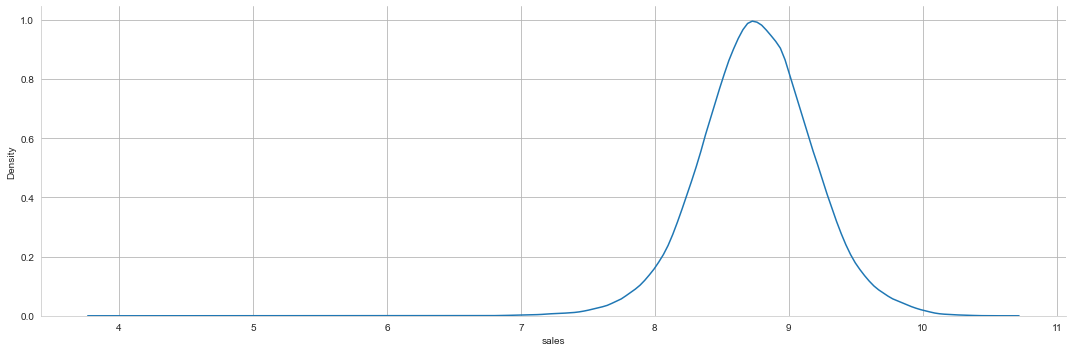

In [568]:
sns.displot(np.log1p(df3['sales']), aspect=3, kind='kde'); # o plt figure figsize não funcionou aqui então tiver que setar o tamanho pelo seaborn

### 5.1.2 NUMERICAL VARIABLE

In [569]:
ax = fig.gca() # aqui o figure figsize também não funcionou e essa foi a forma que achei de mudar o tamanho do plot
num_attributes.hist(ax = ax, bins =25);

### 5.1.2 CATEGORICAL VARIABLE

<AxesSubplot:xlabel='sales', ylabel='Density'>

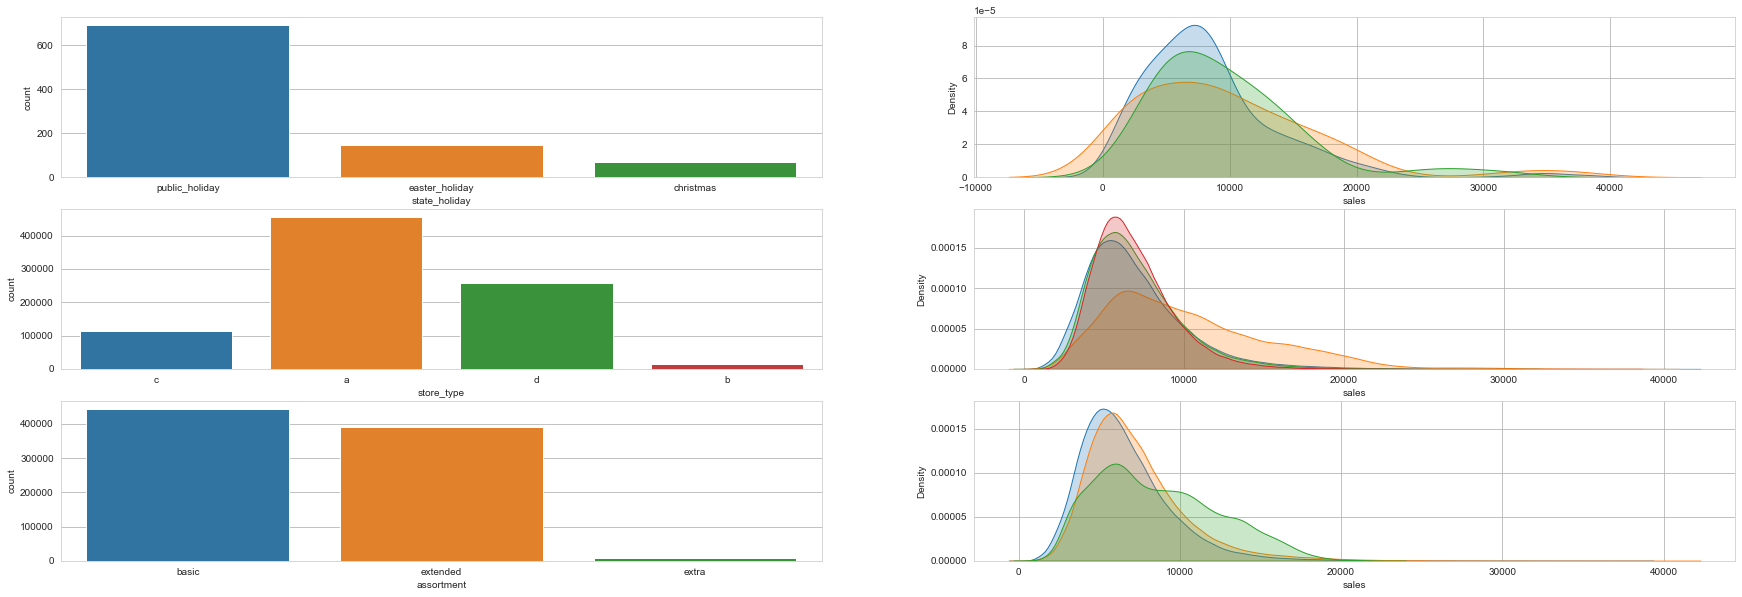

In [570]:
plt.subplot(3, 2, 1)
a = df3[df3['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])
#sns.countplot(df3[df3['state_holiday'] != 'regular_day'])

plt.subplot(3, 2, 2)
sns.kdeplot(df3[df3['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df3[df3['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df3[df3['state_holiday'] == 'christmas']['sales'], label='regular_day', shade=True)

plt.subplot(3, 2, 3)
sns.countplot(df3['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df3[df3['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df3[df3['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df3[df3['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df3[df3['store_type'] == 'd']['sales'], label='d', shade=True)


plt.subplot(3, 2, 5)
sns.countplot(df3['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df3[df3['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df3[df3['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df3[df3['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 5.2 ANÁLISE BIVARIADA

### H1. Lojas com maior sortimento deveriam vender mais

VENDAS POR LOJA:
Basic: 6621.52
Extended: 7300.84
Extra: 8642.5


Acima podemos ver que na verdade o extra é o que tem mais venda por loja, e só tem menos vendas totais pois a quantidade de lojas que possui o tipo 
de assortment extra é muito pequena. Podemos ver também que a loja Extended também vende mais por loja em comparação com a loja com assortment 
Basic, e as lojas com assorment Basic só vende mais no total pois mais lojas possuem esse tipo de assortment


Essa seria a quantidade de vendas que as lojas de assortment extra teriam, se existissem a mesma quantidade desse tipo de loja do que existem lojas do tipo basic: 
3844832187.5


Quantidade de vendas de lojas com assortment basic:
2945748710.0


<AxesSubplot:xlabel='assort', ylabel='sales'>

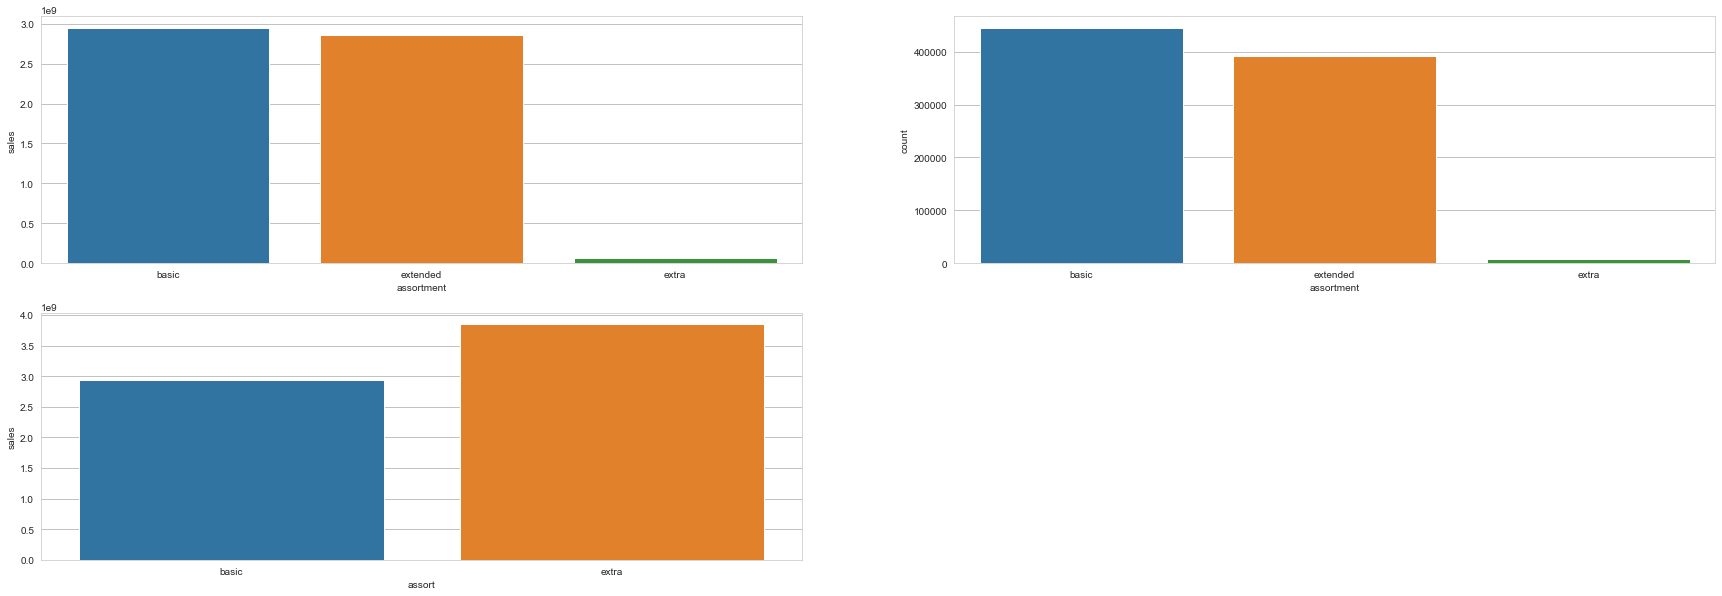

In [571]:
#hipótese falsa, lojas com maior sortimento vendem menos (na verdade existe menos vendas de lojas com assortment maior, mas tambem existem muito..
#...menos lojas com maior assortment, como saber se, se existisses a mesma quantidade de lojas com maior assortment do que as lojas com menor...
#... as vendas não seriam as mesmas? dividir as vendas pela quantidade de lojas pode servir, como fazer isso?
assortment_sales = df3[['sales', 'assortment']].groupby('assortment').sum().reset_index()


# Dividindo a total de vendas pela quantidade de lojas com cada tipo de assortment
print('VENDAS POR LOJA:')

#Soma de vendas das lojas com assortment tipo 'basic' dividido pela quantidade de lojas com o mesmo tipo de assortment
print( f"Basic: {round( assortment_sales['sales'][0] / df3['assortment'].value_counts()[0], 2)}")

#Soma de vendas das lojas com assortment tipo 'extended' dividido pela quantidade de lojas com o mesmo tipo de assortment
print( f"Extended: {round( assortment_sales['sales'][1] / df3['assortment'].value_counts()[1], 2)}")

#Soma de vendas das lojas com assortment tipo 'extra' dividido pela quantidade de lojas com o mesmo tipo de assortment
print( f"Extra: {round( assortment_sales['sales'][2] / df3['assortment'].value_counts()[2], 2 )}")
print('\n')
print("""Acima podemos ver que na verdade o extra é o que tem mais venda por loja, e só tem menos vendas totais pois a quantidade de lojas que possui o tipo 
de assortment extra é muito pequena. Podemos ver também que a loja Extended também vende mais por loja em comparação com a loja com assortment 
Basic, e as lojas com assorment Basic só vende mais no total pois mais lojas possuem esse tipo de assortment""")

#Em um cenário onde a quantidade de lojas com o assortment extra fosse o mesmo da quantidade de lojas com o assortment basic, as lojas com o assor...
#...tment extra teriam vendido: (considerando que as quantidade de loja por venda fosse a mesma.)

print('\n')
#vendas basic 2945750070
print('Essa seria a quantidade de vendas que as lojas de assortment extra teriam, se existissem a mesma quantidade desse tipo de loja do que existem lojas do tipo basic: ')

# Quantidade de lojas com o assortment do tipo 'basic' vezes o valor de vendas por loja do tipo 'extra'
print( (df3['assortment'].value_counts()[0]) * (round(assortment_sales['sales'][2] / df3['assortment'].value_counts()[2], 2 )))
print('\n')
print('Quantidade de vendas de lojas com assortment basic:')

#Quantidade de lojas com o assortment do tipo 'basic' vezes o valor de vendar por loja do mesmo tipo de assortment
print((df3['assortment'].value_counts()[0]) * (round(assortment_sales['sales'][0] / df3['assortment'].value_counts()[0], 2 )) )

# Atribuind os dois valores acima a uma variável para poder criar um dicionario, depois um dataframe e depois fazer um barplot desse dataframe
sales_extra = (df3['assortment'].value_counts()[0]) * (round(assortment_sales['sales'][2] / df3['assortment'].value_counts()[2], 2 ))
sales_basic =(df3['assortment'].value_counts()[0]) * (round(assortment_sales['sales'][0] / df3['assortment'].value_counts()[0], 2 ))

# porcentagem do basic que corresponde ao total de extra
    #Regra de 3
    # (sales_extra / 100 ) * (sales_basic / x)
    # sales_extra * x = sales_basic * 100
    # x = (sales_basic * 100) / sales_extra
x = (sales_basic * 100) / sales_extra
#print(x)

sales_dict = {'assort': ['basic', 'extra'], 'sales': [sales_basic, sales_extra]}
df_sales = pd.DataFrame.from_dict(sales_dict)
# display(df_sales)

#Plotando os gráficos
plt.subplot(2, 2, 1)
sns.barplot(data=assortment_sales, x='assortment', y='sales')

plt.subplot(2, 2, 2)
sns.countplot(df3['assortment'])

plt.subplot(2, 2, 3)
sns.barplot(data=df_sales, x='assort', y='sales')

In [572]:
display(df_sales)

,assort,sales
0,basic,2945748710.00
1,extra,3844832187.50


<AxesSubplot:xlabel='year_week'>

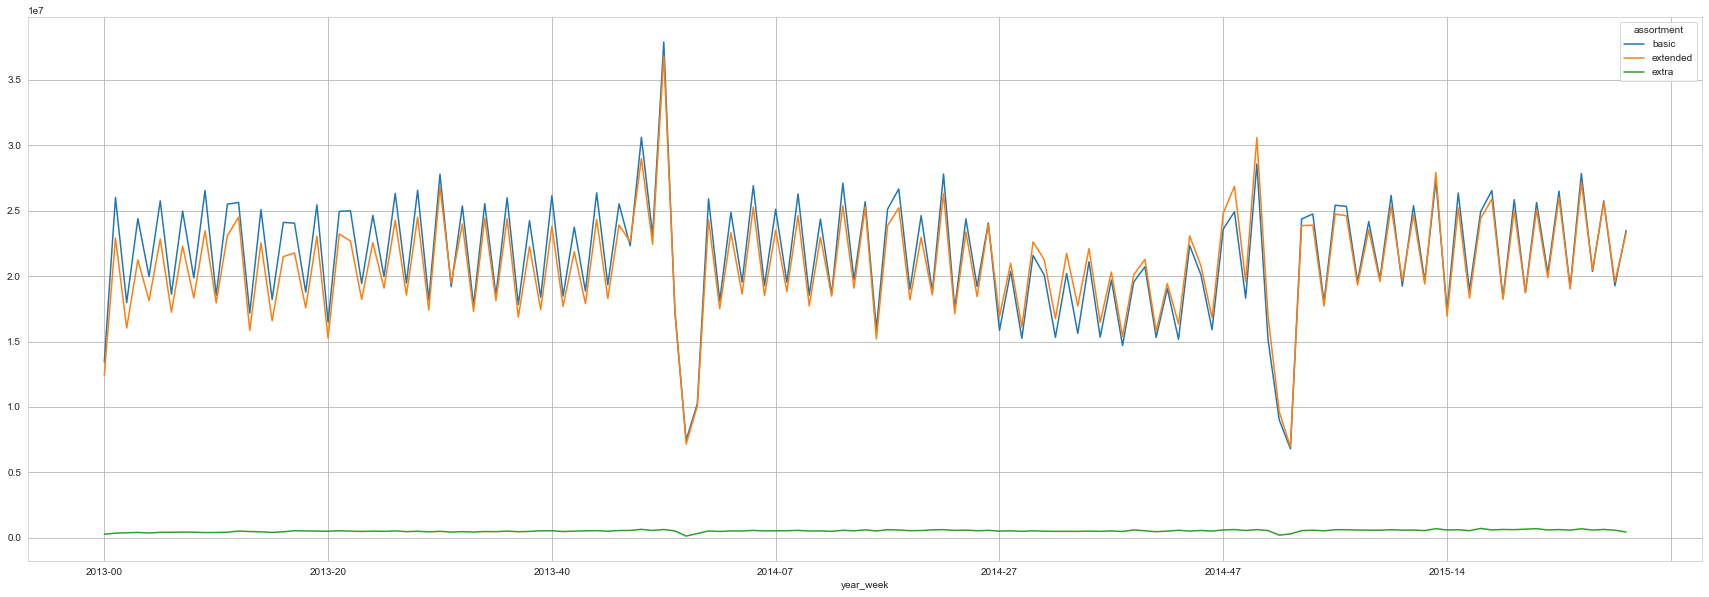

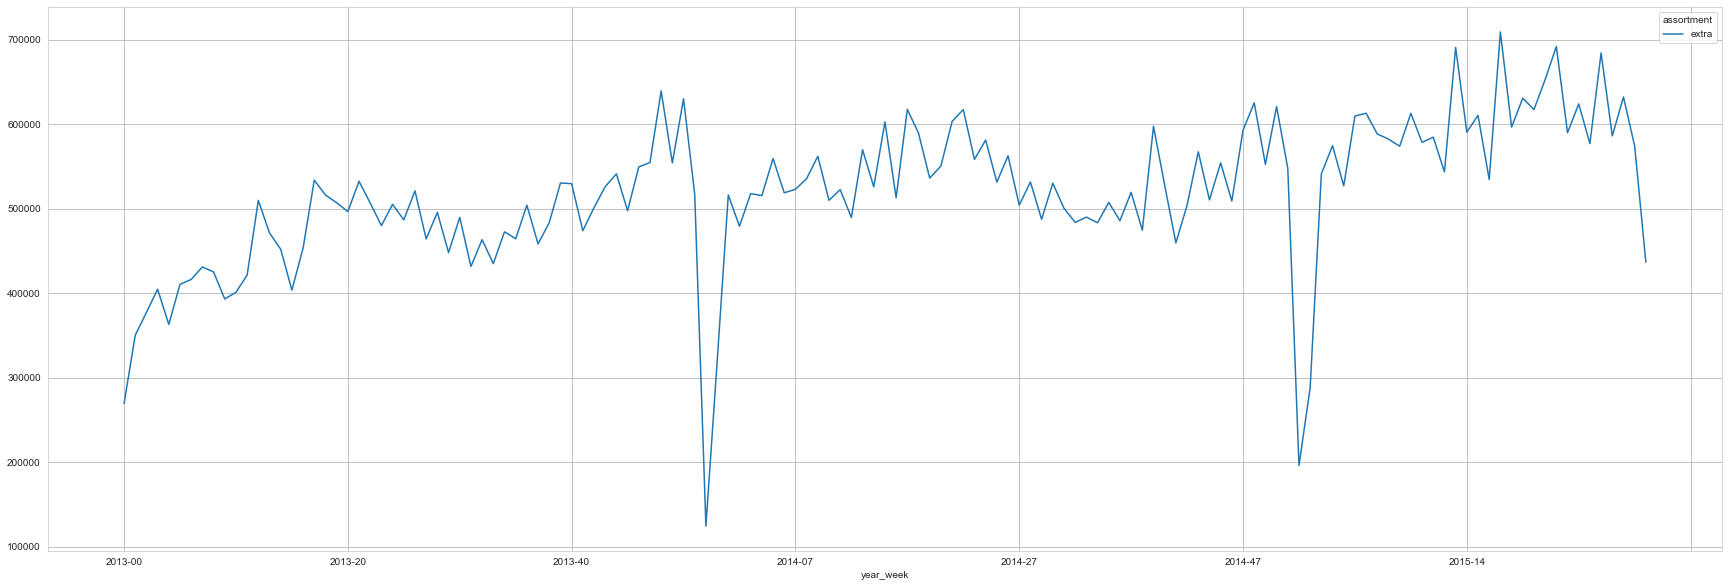

In [573]:
aux = df3[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux.pivot(index='year_week', columns='assortment', values='sales').plot()


aux2 = aux[aux['assortment'] == 'extra']
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()


### H2. Lojas com competidores mais próximos deveriam vender menos

Quantidade de casas com distância menores que 3000: 472992
Quantidade de casas com distância entre 3000 e 6000: 137556
Quantidade de casas com distância maiores que 6000: 233790


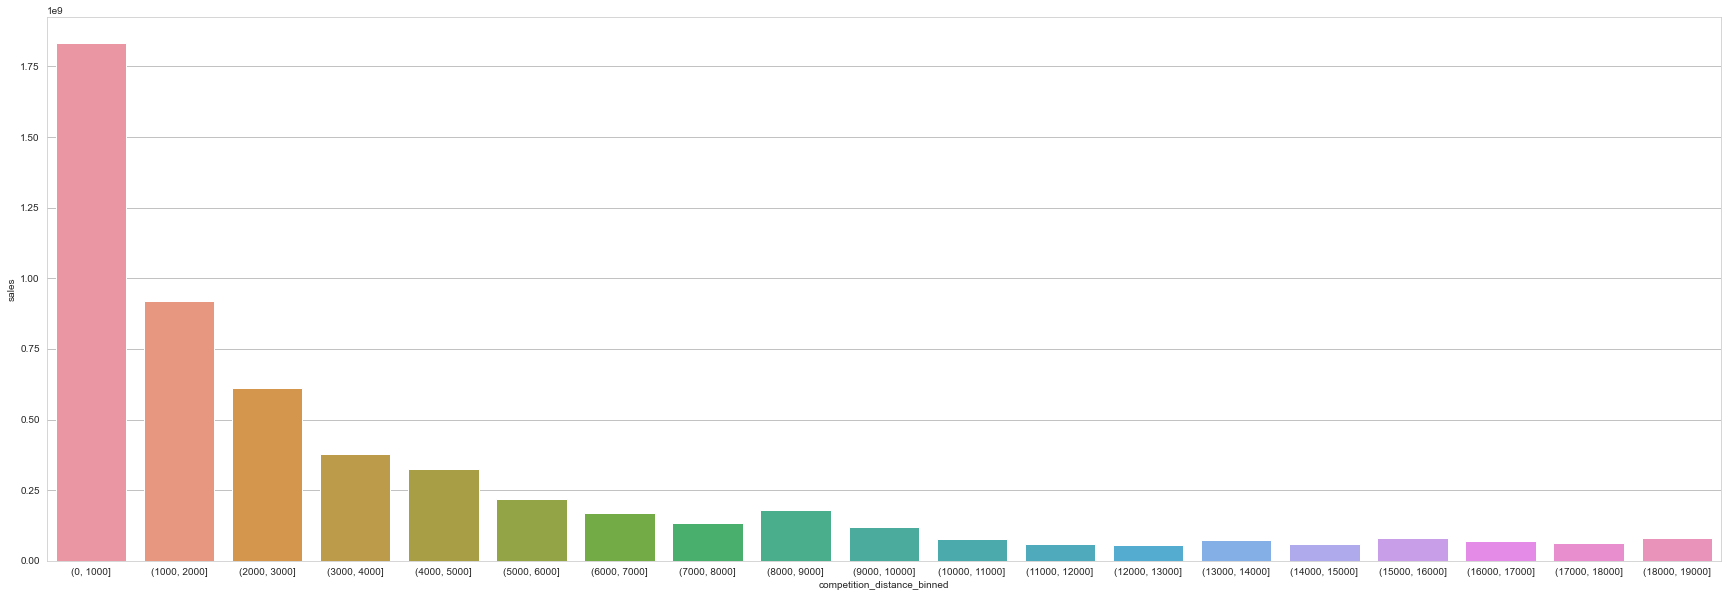

In [574]:
aux = df3[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0, 20000, 1000))
aux['competition_distance_binned'] = pd.cut(aux['competition_distance'], bins=bins)
aux2 = aux[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(data=aux2, x='competition_distance_binned', y='sales')

print( f"Quantidade de casas com distância menores que 3000: {len ( df3[df3['competition_distance'] <= 3000] )}" )
print( f"Quantidade de casas com distância entre 3000 e 6000: {len ( df3[ (df3['competition_distance'] > 3000) & (df3['competition_distance'] <= 6000)] )}" )
print( f"Quantidade de casas com distância maiores que 6000: {len ( df3[df3['competition_distance'] > 6000] )}")



### H3 Lojas com competidores à mais tempo vendem mais.

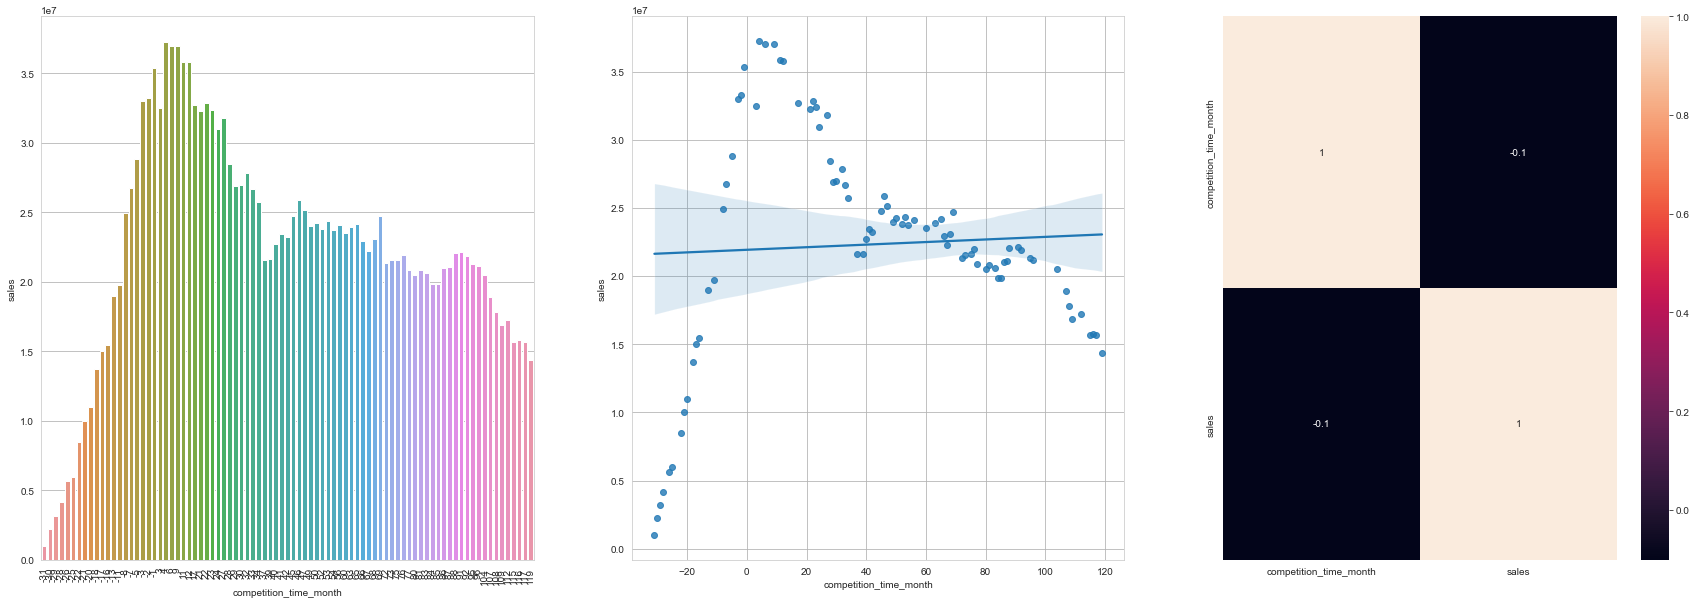

In [575]:
aux = df3[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux[(aux['competition_time_month'] < 120) & aux['sales'] != 0]

plt.subplot(1, 3, 1)
sns.barplot(data=aux2, x='competition_time_month', y='sales')
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(data=aux2, x='competition_time_month', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr( method='pearson'), annot=True);

In [576]:
df3.sample(20)

,store,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,day_of_week,date,sales,promo,state_holiday,school_holiday,is_promo,year,month,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
160958,178,d,basic,1710,4,2014,0,15,2014,1,2014-04-07,8351,0,regular_day,0,0,2014,4,15,2014-14,2014-04-01,0,2014-03-31,1
539163,591,a,extended,3340,3,2013,1,22,2012,3,2013-03-20,6226,1,regular_day,0,1,2013,3,12,2013-11,2013-03-01,0,2012-05-14,44
877128,962,c,basic,260,1,2013,0,1,2013,5,2013-01-04,5293,0,regular_day,1,0,2013,1,1,2013-00,2013-01-01,0,2012-12-24,1
391930,430,d,extended,12870,10,2008,0,10,2013,4,2013-03-07,7814,1,regular_day,0,0,2013,3,10,2013-09,2008-10-01,53,2013-02-25,1
503691,553,c,basic,3040,9,2002,1,13,2010,4,2014-11-06,8215,1,regular_day,0,0,2014,11,45,2014-44,2002-09-01,148,2010-03-15,242
772200,848,a,extended,370,7,2007,1,14,2011,3,2015-05-06,7321,1,regular_day,0,0,2015,5,19,2015-18,2007-07-01,95,2011-03-21,215
112775,124,a,basic,1410,4,2003,0,25,2014,6,2014-06-21,2320,0,regular_day,0,0,2014,6,25,2014-24,2003-04-01,136,2014-06-09,1
24752,27,a,basic,60,1,2005,1,5,2011,5,2013-05-10,10581,0,regular_day,0,0,2013,5,19,2013-18,2005-01-01,101,2011-01-17,120
912691,1001,c,basic,19640,3,2014,1,14,2011,2,2014-03-18,7079,1,regular_day,0,0,2014,3,12,2014-11,2014-03-01,0,2011-03-21,156
469653,515,d,extended,11260,7,2013,1,9,2011,3,2013-07-24,7601,0,regular_day,1,0,2013,7,30,2013-29,2013-07-01,0,2011-02-14,127


### H4. Lojas com promoções ativas por mais tempo deveriam vender mais

In [ ]:
print( df3['promo_time_week'].mean() )
print( df3['promo_time_week'].median() )
print( df3['promo_time_week'].min() )
print( df3['promo_time_week'].max())
# print( df3['promo_time_week'].unique())

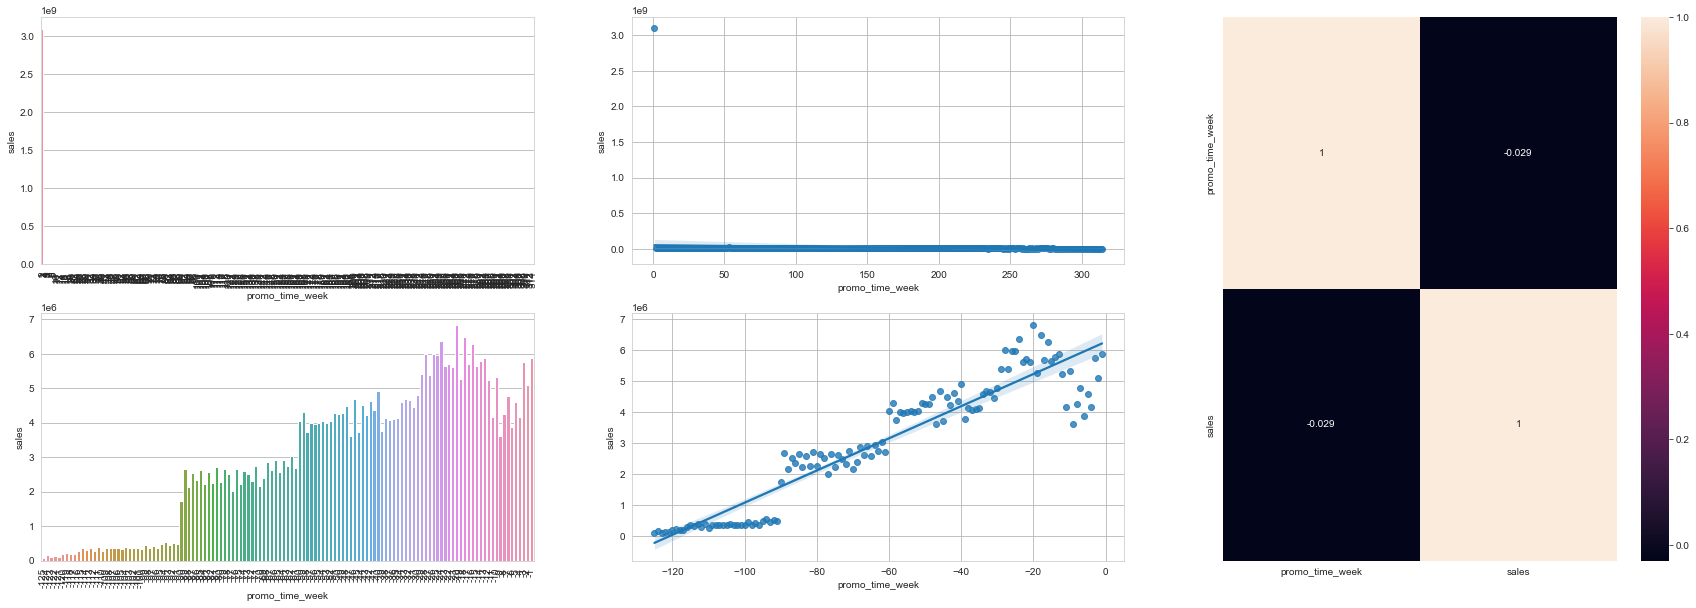

In [578]:
aux = df3[['sales', 'promo_time_week']].groupby('promo_time_week').sum().reset_index()
aux2 = aux[aux['promo_time_week'] > 0] # promo2
aux3 = aux[aux['promo_time_week'] < 0] # Promo2

Grid = grid.GridSpec(2, 3)

plt.subplot(Grid[0, 0])
sns.barplot(data=aux2, x='promo_time_week', y='sales')
plt.xticks(rotation=90)

plt.subplot(Grid[0, 1])
sns.regplot(data=aux2, x='promo_time_week', y='sales')

plt.subplot(Grid[1, 0])
sns.barplot(data=aux3, x='promo_time_week', y='sales')
plt.xticks(rotation=90)

plt.subplot(Grid[1, 1])
sns.regplot(data=aux3, x='promo_time_week', y='sales')

plt.subplot(Grid[:, 2])
sns.heatmap(aux.corr(method='pearson'), annot=True);

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.

In [579]:
# Aqui as lojas com ambas as promoções venderam pouco, mas será que não existem poucas lojas que tiveram as duas promoções?
df3[['sales', 'promo', 'promo2']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


<AxesSubplot:xlabel='is_promo', ylabel='count'>

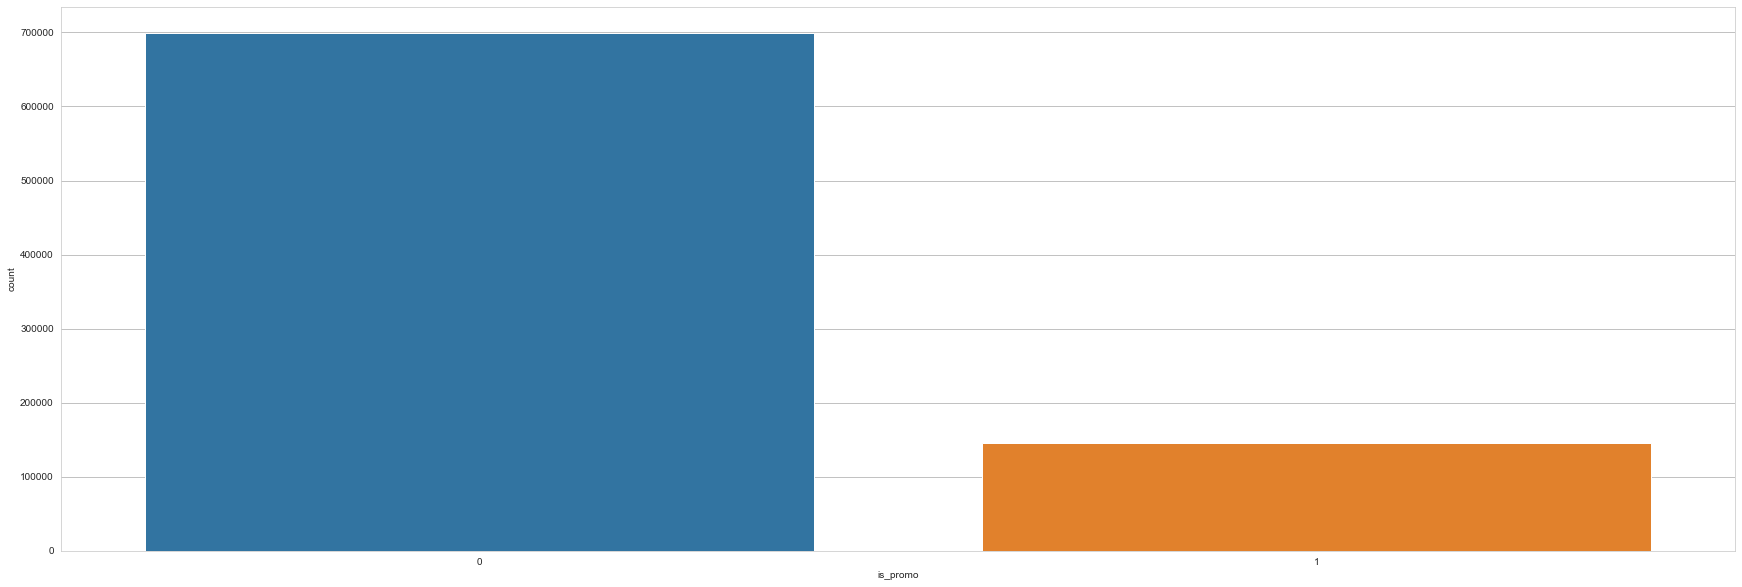

In [580]:
#Aqui podemos ver que poucas lojas aderiram a segunda promoção, por isso há menos vendas.
sns.countplot(df3['is_promo'])

# Pulei a o resto da EDA, depois eu volto. (Refazer depois considerando a quantidade de variável com determinada característica. - como fiz com as lojas com maior sortimento. ex. Lojas com promoção extendida vendem menos, mas existem muito menos lojas que aderiram a segunda promoção do que as que não aderiram, então não basta apenas ver a soma de venda total, é preciso dividir a soma da venda total pela quantidade de lojas com cada tipo de promoção. Fazer um 'sales per store' para cada feature (sabendo que não é exato pois cada numero de vendas de uma feature também é influenciada por outras features da mesma loja)

In [581]:
aux2

,promo_time_week,sales
126,1,3099559736
127,2,6143850
128,3,6086498
129,4,5838757
130,5,6438274
...,...,...
435,310,360433
436,311,277156
437,312,353546
438,313,268970


### H5. Lojas com mais dias de promoção deveriam vender mais.

### H6. Lojas com mais promoções consecutivas deveriam vender mais.

# 6. DATA PREPARATION

In [593]:
df4 = df3.copy()

## 6.1 RESCALING

In [583]:
# Competition_distance
rs = RobustScaler()
df4['competition_distance'] = rs.fit_transform(df4[['competition_distance']].values)

# competition_time_month
df4['competition_time_month'] = rs.fit_transform(df4[['competition_time_month']].values)

# promo_time_week
mms = MinMaxScaler()
df4['promo_time_week'] = mms.fit_transform(df4[['promo_time_week']].values)

#year
mms = MinMaxScaler()
df4['year'] = mms.fit_transform(df4[['promo_time_week']].values)

## 6.3 TRANSFORMAÇÃO

### 6.2.1 ENCODING

In [584]:
#state_holiday - One Hot Encoding
df4 = pd.get_dummies( df4, prefix=['state_holiday'], columns=['state_holiday'])

# Assortment - Ordinal Enconding
assort = {'basic': 1, 'extended': 2, 'extra': 3}
df4['assortment'] = df4['assortment'].map(assort)

# store_type - Label Encoder
le = LabelEncoder()
df4['store_type'] = le.fit_transform(df4['store_type'])

### 6.2.2 Transformação da variável resposta

In [585]:
df3['sales'] = np.log1p(df3['sales'])

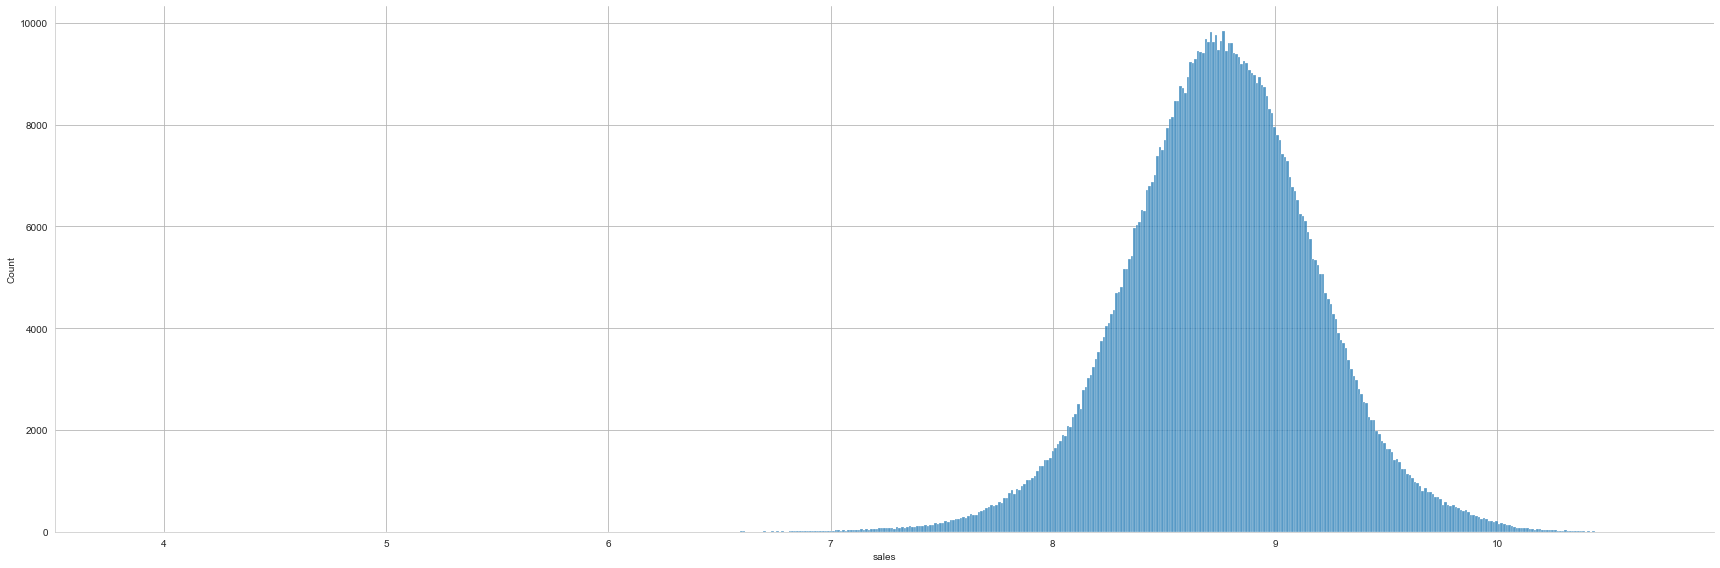

In [586]:
sns.displot(df3['sales'], height=8, aspect=3)

### Tranformação de Natureza da Variável.

In [594]:
#weekofyear
df4['week_of_year_sin'] = df4['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52 )))
df4['week_of_year_cos'] = df4['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52 )))

#month
df4['month_sin'] = df4['month'].apply(lambda x: np.sin( x * (2. * np.pi / 12)))
df4['month_cos'] = df4['month'].apply(lambda x: np.cos( x * (2. * np.pi / 12)))

#day
df4['day_sin'] = df4['day'].apply(lambda x: np.sin( x * ( 2. * np.pi / 30)))
df4['day_cos'] = df4['day'].apply(lambda x: np.cos( x * ( 2. * np.pi / 30)))

#dayofweek
df4['day_of_week_sin'] = df4['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi / 7)))
df4['day_of_week_cos'] = df4['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi / 7)))

In [588]:
df4.head(1)

,store,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,day_of_week,date,sales,promo,school_holiday,is_promo,year,month,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,week_of_year_sin,week_of_year_cos,month_sin,month_cos
0,1,2,1,-0.17,9,2008,0,31,2015,5,2015-07-31,5263,1,1,0,0.29,7,31,2015-30,2008-09-01,0.92,2015-07-20,0.29,0,0,0,1,-0.57,-0.82,-0.50,-0.87
